In [1]:
from fastai.vision.all import *
import fastai
import timm
import pandas as pd

In [2]:
import torch
torch.cuda.set_device(3)

In [3]:
df = pd.read_csv('../dataset.csv')

In [4]:
df = df.drop(df[df.masa<0].index)

In [5]:
dftrain = df[(df.split=='train') | (df.split=='valid')]
dftest = df[(df.split=='test')]

In [6]:
# !mkdir ../datasetClean/train
# !mkdir ../datasetClean/test

In [7]:
# import shutil
# from imutils import paths

In [8]:
# for image in dftrain.image_id.values:
#     shutil.move(image.replace('datasetClean','../datasetClean'),
#                 image.replace('datasetClean','../datasetClean/train'))

In [9]:
# for image in dftest.image_id.values:
#     shutil.move(image.replace('datasetClean','../datasetClean'),
#                 image.replace('datasetClean','../datasetClean/test'))

In [10]:
# df.volumen.describe()

In [11]:
def get_masa(f):
    return float(df[df['image_id']=='datasetClean/'+f.name]['masa'])

def get_volumen(f):
    return float(df[df['image_id']=='datasetClean/'+f.name]['volumen'])

def is_valid(f):
    return (df[df['image_id']=='datasetClean/'+f.name]['split']).values[0]=='valid'

In [12]:
def getDataBlock(presize=512,size=512):
    return DataBlock(blocks = (ImageBlock, RegressionBlock()),
                 get_items=get_image_files, 
                 splitter=FuncSplitter(is_valid),
                 get_y=get_masa,
                 item_tfms = Resize(presize),
                 batch_tfms=[*aug_transforms(size=size,flip_vert=True,
                                            max_zoom=1.0), Normalize.from_stats(*imagenet_stats)])

In [13]:
path = Path('../datasetClean/')
trainPath = path/'train'

In [14]:
db = getDataBlock()
dls = db.dataloaders(trainPath,bs=8)

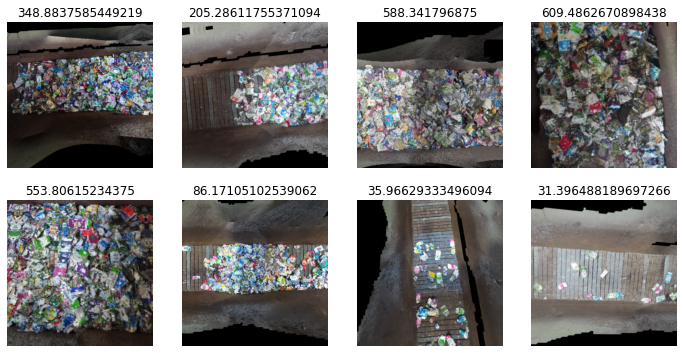

In [15]:
dls.show_batch()

In [16]:
from fastai.vision.all import *
callbacks = [
    ShowGraphCallback(),
    #EarlyStoppingCallback(patience=3),
    SaveModelCallback(fname='efficientnetv2_rw_s_masa')
]

In [17]:
from fastai.metrics import mae,rmse,mse

In [18]:
learn = Learner(dls, timm.create_model('efficientnetv2_rw_s',num_classes=1,pretrained=True),
                loss_func=MSELossFlat(), metrics=[mae,rmse,mse],cbs=callbacks).to_fp16()

In [19]:
# learn.lr_find()

epoch,train_loss,valid_loss,mae,_rmse,mse,time
0,79808.671875,33600.820312,127.510849,183.305267,33600.820312,00:09


Better model found at epoch 0 with valid_loss value: 33600.8203125.


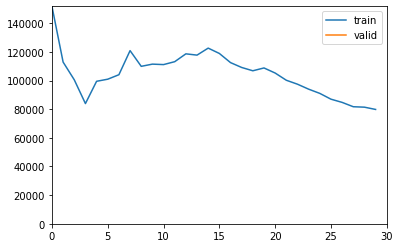

epoch,train_loss,valid_loss,mae,_rmse,mse,time
0,22117.222656,17903.669922,89.529190,133.804596,17903.669922,00:07
1,18593.988281,13216.864258,81.669441,114.964622,13216.864258,00:08
2,16926.210938,8300.693359,65.099487,91.108139,8300.693359,00:08
3,14276.892578,10048.296875,76.919510,100.241196,10048.296875,00:08
4,11651.978516,7224.949219,61.405457,84.999702,7224.949219,00:08
5,10869.125977,3934.637939,44.194836,62.726692,3934.637939,00:09
6,10396.120117,6108.172852,58.384556,78.154800,6108.172852,00:08
7,10687.495117,4423.450195,47.888786,66.509026,4423.450195,00:08
8,9947.396484,5210.394531,54.311485,72.183060,5210.394531,00:08
9,10193.363281,4748.184082,52.911594,68.907066,4748.184082,00:08


Better model found at epoch 0 with valid_loss value: 17903.669921875.


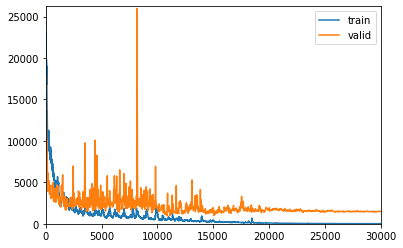

Better model found at epoch 1 with valid_loss value: 13216.8642578125.
Better model found at epoch 2 with valid_loss value: 8300.693359375.
Better model found at epoch 4 with valid_loss value: 7224.94921875.
Better model found at epoch 5 with valid_loss value: 3934.637939453125.
Better model found at epoch 10 with valid_loss value: 3801.88671875.
Better model found at epoch 11 with valid_loss value: 3520.524658203125.
Better model found at epoch 15 with valid_loss value: 3060.97802734375.
Better model found at epoch 22 with valid_loss value: 2828.73974609375.
Better model found at epoch 23 with valid_loss value: 2820.657958984375.
Better model found at epoch 24 with valid_loss value: 2664.08984375.
Better model found at epoch 29 with valid_loss value: 2596.035400390625.
Better model found at epoch 38 with valid_loss value: 2348.03662109375.
Better model found at epoch 43 with valid_loss value: 2018.6939697265625.
Better model found at epoch 58 with valid_loss value: 1675.156494140625.


In [20]:
learn.fine_tune(1000,base_lr=1e-3)

In [21]:
learn.load('efficientnetv2_rw_s_masa')

/home/jonathan/.virtualenvs/segmentation/lib/python3.6/site-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


In [22]:
def is_test(f):
    return (df[df['image_id']=='datasetClean/'+f.name]['split']).values[0]=='test'

In [23]:
dbtest = DataBlock(blocks = (ImageBlock, RegressionBlock()),
                 get_items=get_image_files, 
                 splitter=FuncSplitter(is_test),
                 get_y=get_masa,
                 item_tfms = Resize(512),
                 batch_tfms=[*aug_transforms(size=512,flip_vert=True,
                                            max_zoom=1.0), Normalize.from_stats(*imagenet_stats)])

In [24]:
dlstest = dbtest.dataloaders(path,bs=8)

In [25]:
learn.dls=dlstest

In [26]:
learn.validate()

Better model found at epoch 0 with valid_loss value: 30.759315490722656.


(#4) [3282.977783203125,30.759315490722656,57.29727554321289,3282.977783203125]

In [27]:
from sklearn.metrics import mean_absolute_error

In [28]:
preds,gt = learn.tta()

In [29]:
mean_absolute_error(gt,preds)

28.524553